In [3]:
# %load ../src/goes16_utils.py
# Training: Python and GOES-R Imagery: Script 8 - Functions for download data from AWS
#-----------------------------------------------------------------------------------------------------------
# Required modules
import os                                # Miscellaneous operating system interfaces
import numpy as np                       # Import the Numpy package
import colorsys                          # To make convertion of colormaps
import boto3                             # Amazon Web Services (AWS) SDK for Python
from botocore import UNSIGNED            # boto3 config
from botocore.config import Config       # boto3 config
import math                              # Mathematical functions
from datetime import datetime            # Basic Dates and time types
from osgeo import osr                    # Python bindings for GDAL
from osgeo import gdal                   # Python bindings for GDAL

#from netCDF4 import Dataset          # Read / Write NetCDF4 files
#import matplotlib.pyplot as plt      # Plotting library
#import cartopy, cartopy.crs as ccrs  # Plot maps
##import sys
#from datetime import timedelta, date, datetime   # Manipulate dates

#-----------------------------------------------------------------------------------------------------------
def loadCPT(path):

    try:
        f = open(path)
    except:
        print ("File ", path, "not found")
        return None

    lines = f.readlines()

    f.close()

    x = np.array([])
    r = np.array([])
    g = np.array([])
    b = np.array([])

    colorModel = 'RGB'

    for l in lines:
        ls = l.split()
        if l[0] == '#':
            if ls[-1] == 'HSV':
                colorModel = 'HSV'
                continue
            else:
                continue
        if ls[0] == 'B' or ls[0] == 'F' or ls[0] == 'N':
            pass
        else:
            x=np.append(x,float(ls[0]))
            r=np.append(r,float(ls[1]))
            g=np.append(g,float(ls[2]))
            b=np.append(b,float(ls[3]))
            xtemp = float(ls[4])
            rtemp = float(ls[5])
            gtemp = float(ls[6])
            btemp = float(ls[7])

        x=np.append(x,xtemp)
        r=np.append(r,rtemp)
        g=np.append(g,gtemp)
        b=np.append(b,btemp)

    if colorModel == 'HSV':
        for i in range(r.shape[0]):
            rr, gg, bb = colorsys.hsv_to_rgb(r[i]/360.,g[i],b[i])
        r[i] = rr ; g[i] = gg ; b[i] = bb

    if colorModel == 'RGB':
        r = r/255.0
        g = g/255.0
        b = b/255.0

    xNorm = (x - x[0])/(x[-1] - x[0])

    red   = []
    blue  = []
    green = []

    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    colorDict = {'red': red, 'green': green, 'blue': blue}

    return colorDict
#-----------------------------------------------------------------------------------------------------------
def download_CMI(yyyymmddhhmn, band, path_dest):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'
  product_name = 'ABI-L2-CMIPF'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6C{int(band):02.0f}_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Band-{band}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

#-----------------------------------------------------------------------------------------------------------
def download_PROD(yyyymmddhhmn, product_name, path_dest):

  # os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'

  # Initializes the S3 client
  # s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Product: {product_name}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # print(f'File name: {file_name}')

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        # print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

#-----------------------------------------------------------------------------------------------------------
def download_GLM(yyyymmddhhmnss, path_dest):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%H')
  min = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%M')
  seg = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%S')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  product_name = "GLM-L2-LCFA"
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}_G16_s{year}{day_of_year}{hour}{min}{seg}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmnss}, Product-{product_name}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

#-----------------------------------------------------------------------------------------------------------
# Functions to convert lat / lon extent to array indices
def geo2grid(lat, lon, nc):

    # Apply scale and offset
    xscale, xoffset = nc.variables['x'].scale_factor, nc.variables['x'].add_offset
    yscale, yoffset = nc.variables['y'].scale_factor, nc.variables['y'].add_offset

    x, y = latlon2xy(lat, lon)
    col = (x - xoffset)/xscale
    lin = (y - yoffset)/yscale
    return int(lin), int(col)

def latlon2xy(lat, lon):
    # goes_imagery_projection:semi_major_axis
    req = 6378137 # meters
    #  goes_imagery_projection:inverse_flattening
    invf = 298.257222096
    # goes_imagery_projection:semi_minor_axis
    rpol = 6356752.31414 # meters
    e = 0.0818191910435
    # goes_imagery_projection:perspective_point_height + goes_imagery_projection:semi_major_axis
    H = 42164160 # meters
    # goes_imagery_projection: longitude_of_projection_origin
    lambda0 = -1.308996939

    # Convert to radians
    latRad = lat * (math.pi/180)
    lonRad = lon * (math.pi/180)

    # (1) geocentric latitude
    Phi_c = math.atan(((rpol * rpol)/(req * req)) * math.tan(latRad))
    # (2) geocentric distance to the point on the ellipsoid
    rc = rpol/(math.sqrt(1 - ((e * e) * (math.cos(Phi_c) * math.cos(Phi_c)))))
    # (3) sx
    sx = H - (rc * math.cos(Phi_c) * math.cos(lonRad - lambda0))
    # (4) sy
    sy = -rc * math.cos(Phi_c) * math.sin(lonRad - lambda0)
    # (5)
    sz = rc * math.sin(Phi_c)

    # x,y
    x = math.asin((-sy)/math.sqrt((sx*sx) + (sy*sy) + (sz*sz)))
    y = math.atan(sz/sx)

    return x, y

# Function to convert lat / lon extent to GOES-16 extents
def convertExtent2GOESProjection(extent):
    # GOES-16 viewing point (satellite position) height above the earth
    GOES16_HEIGHT = 35786023.0
    # GOES-16 longitude position
    GOES16_LONGITUDE = -75.0

    a, b = latlon2xy(extent[1], extent[0])
    c, d = latlon2xy(extent[3], extent[2])
    return (a * GOES16_HEIGHT, c * GOES16_HEIGHT, b * GOES16_HEIGHT, d * GOES16_HEIGHT)

#-----------------------------------------------------------------------------------------------------------
# Function to reproject the data
def reproject(file_name, ncfile, array, extent, undef):

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(ncfile.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = ncfile.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', array.shape[0], array.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(array)

    # Define the parameters of the output file
    kwargs = {'format': 'netCDF', \
            'srcSRS': source_prj, \
            'dstSRS': target_prj, \
            'outputBounds': (extent[0], extent[3], extent[2], extent[1]), \
            'outputBoundsSRS': target_prj, \
            'outputType': gdal.GDT_Float32, \
            'srcNodata': undef, \
            'dstNodata': 'nan', \
            'resampleAlg': gdal.GRA_NearestNeighbour}

    # Write the reprojected file on disk
    gdal.Warp(file_name, raw, **kwargs)

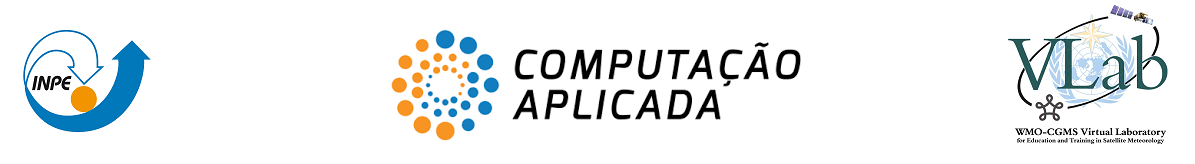

## Link do curso

###https://www.youtube.com/watch?v=ESlTKAGRgbY

## Preparando o ambiente

In [ ]:
!cat /etc/issue
!uname -a

Ubuntu 18.04.5 LTS \n \l

Linux 54728b5e7a86 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
!python --version

Python 3.7.10


In [ ]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


###Instalando o netcdf4

In [ ]:
pip install netcdf4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.9 MB/s eta 0:00:00


###Instalando o cartopy

In [ ]:
pip uninstall -y shapely imgaug

Found existing installation: shapely 2.0.4
Uninstalling shapely-2.0.4:
  Successfully uninstalled shapely-2.0.4
Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.3 MB/s eta 0:00:00


In [ ]:
pip install shapely --no-binary shapely --force

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Created wheel for shapely: filename=shapely-2.0.4-cp310-cp310-linux_x86_64.whl size=1030327 sha256=ba95835c3e3cdc4c4d7a2b7a8b5609879c9cea1c2f0469fae6d07420452ddb70
  Stored in directory: /root/.cache/pip/wheels/85/0b/57/c3140e472fde452aa215492a886f7859aeba06f6b47ae35ee9
Successfully built shapely
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.4
    Uninsta

##Instalando boto3

In [ ]:
pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.4 MB/s eta 0:00:00


###Atualizando a gdal

In [ ]:
!dpkg -l | grep libgdal

ii  libgdal-dev                               3.6.4+dfsg-1~jammy0                     amd64        Geospatial Data Abstraction Library - Development files
ii  libgdal32                                 3.6.4+dfsg-1~jammy0                     amd64        Geospatial Data Abstraction Library


In [ ]:
!ogrinfo --version

/bin/bash: line 1: ogrinfo: command not found


In [ ]:
!apt-add-repository -y ppa:ubuntugis/ubuntugis-unstable
!add-apt-repository -y ppa:ubuntugis/ppa

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu/ jammy main'
Description:
Unstable releases of Ubuntu GIS packages. These releases are more bleeding edge and while generally they should work well, they dont receive the same amount of quality assurance as our stable releases do.
More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ubuntugis-unstable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ubuntugis-unstable.gpg with fingerprint 6B827C12C2D425E227EDCA75089EBE08314DF160
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 htt

In [ ]:
!apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
99 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [ ]:
!apt upgrade

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Calculating upgrade... Done
The following packages were automatically installed and are no longer required:
  libgdal32 libgeos3.11.1 libspatialite7
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  libgdal34 libgeos3.12.1 libspatialite8 proj-bin
The following packages have been kept back:
  libcudnn8 libcudnn8-dev libnccl-dev libnccl2
The following packages will be upgraded:
  base-files bash binutils binutils-common binutils-x86-64-linux-gnu bsdutils coreutils
  cuda-compat-12-2 cuda-keyring cuda-toolkit-12-config-common cuda-toolkit-config-common dpkg
  dpkg-dev gdal-data gdal-plugins libbinutils libblkid1 libc-bin libctf-nobfd0 libctf0 libdpkg-perl
  libfreexl-dev libfreexl1 libgdal-dev libgeos-c1v5 libgeos-dev libgeotiff-dev libgeotiff5
  libgnutls30 libldap-2.5-0 libmount1 libopencv-calib3d-dev libopencv-calib3d4.5d
  libopencv-contrib-dev libopencv-

In [ ]:
!apt-get install gdal-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libgdal32 libgeos3.11.1 libspatialite7
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu jammy/mai

In [ ]:
!ogrinfo --version

GDAL 3.8.4, released 2024/02/08


In [ ]:
pip install 'gdal==3.0.4'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.2/577.2 kB 6.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


##Download de arquivos auxiliares

In [ ]:
#!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
!wget -c https://www.dropbox.com/s/514312gwhstn5r9/br_unidades_da_federacao.zip
!unzip br_unidades_da_federacao.zip

--2024-05-15 16:51:05--  https://www.dropbox.com/s/514312gwhstn5r9/br_unidades_da_federacao.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/514312gwhstn5r9/br_unidades_da_federacao.zip [following]
--2024-05-15 16:51:06--  https://www.dropbox.com/s/raw/514312gwhstn5r9/br_unidades_da_federacao.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1bb6b005f59b6539cb723f673e.dl.dropboxusercontent.com/cd/0/inline/CS9Zmb0cbJlHogHSS3TetldvMuCzEBy0-4mcvuiHCye0NVmNXqfEnZPV2XJqnJtWlmBxJ7UTsNcnaTr1YL0X4eZvhQ4-IeW_4KRkybXnAwbN17FauxYUhi2tdMPak59RkEo/file# [following]
--2024-05-15 16:51:07--  https://uc1bb6b005f59b6539cb723f673e.dl.dropboxusercontent.com/cd/0/inline/CS9Zmb0cbJlHogHSS3TetldvMuCzEBy0-4mcvuiHCye0NVmNXqfEnZPV2XJqnJtWlmBxJ7UT

In [ ]:
!wget -c https://www.dropbox.com/s/fdgnaqt91cy3x97/IR4AVHRR6.cpt

--2024-05-15 16:51:23--  https://www.dropbox.com/s/fdgnaqt91cy3x97/IR4AVHRR6.cpt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fdgnaqt91cy3x97/IR4AVHRR6.cpt [following]
--2024-05-15 16:51:23--  https://www.dropbox.com/s/raw/fdgnaqt91cy3x97/IR4AVHRR6.cpt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc104454bfff84aaf01782d1a82e.dl.dropboxusercontent.com/cd/0/inline/CS_rubN1XTWVhOPzsSFLWFX4hIpxxpksmPIdlsOpXsIeMYud3hFkq4P_y_uQZ8muoZyqL_VFUbqF2iCc69UzBg4W25GRbNOrQwbGSppR_TFhWC6TgdzZO80dUgNZpUqpUKw/file# [following]
--2024-05-15 16:51:24--  https://uc104454bfff84aaf01782d1a82e.dl.dropboxusercontent.com/cd/0/inline/CS_rubN1XTWVhOPzsSFLWFX4hIpxxpksmPIdlsOpXsIeMYud3hFkq4P_y_uQZ8muoZyqL_VFUbqF2iCc69UzBg4W25GRbNOrQwbGSppR_TFhWC6TgdzZO

In [ ]:
!wget -c https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py

--2024-05-15 16:51:29--  https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/i8j1g9xg1g7o56l/utilities.py [following]
--2024-05-15 16:51:29--  https://www.dropbox.com/s/raw/i8j1g9xg1g7o56l/utilities.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfccba1e0ec22a80a90efa19aa9.dl.dropboxusercontent.com/cd/0/inline/CS-wh_amJK40yHk6y4E4fD7cP1jrVhiu69Ly0yiJGQXDhVx6zh43GdaoT-Ubx2IPFzbhsC-PCcT81cWI5MfJN7SiSRMUAdnMOsgCuwOdHT7DkzsVjaI_pahD4laVJugDRH8/file# [following]
--2024-05-15 16:51:30--  https://ucfccba1e0ec22a80a90efa19aa9.dl.dropboxusercontent.com/cd/0/inline/CS-wh_amJK40yHk6y4E4fD7cP1jrVhiu69Ly0yiJGQXDhVx6zh43GdaoT-Ubx2IPFzbhsC-PCcT81cWI5MfJN7SiSRMUAdnMOsgCuwOdHT7DkzsVjaI_pahD

In [ ]:
!wget -c https://www.dropbox.com/s/1ii0x5x87322rl5/pluvio_inmet_20201217.txt

--2024-05-15 16:51:33--  https://www.dropbox.com/s/1ii0x5x87322rl5/pluvio_inmet_20201217.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1ii0x5x87322rl5/pluvio_inmet_20201217.txt [following]
--2024-05-15 16:51:33--  https://www.dropbox.com/s/raw/1ii0x5x87322rl5/pluvio_inmet_20201217.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc36c9729cdc7408add9806305d1.dl.dropboxusercontent.com/cd/0/inline/CS8FQO-EuVbI8CVMzDI1f8Xe4V1roGbZjkL8P9fhRKmp0djVDwl0sxhtIEQ61-O-h6BpytkkxbupUHRiH5PS12Dmc4Qo9vdA92PwgBicwkxEw1nkPKY3yclfKZZ3UIXuEPg/file# [following]
--2024-05-15 16:51:34--  https://uc36c9729cdc7408add9806305d1.dl.dropboxusercontent.com/cd/0/inline/CS8FQO-EuVbI8CVMzDI1f8Xe4V1roGbZjkL8P9fhRKmp0djVDwl0sxhtIEQ61-O-h6BpytkkxbupUHRiH

In [ ]:
!mkdir -p Samples
!mkdir -p Output

In [ ]:
!wget -c https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/198/12/OR_ABI-L2-CMIPF-M6C08_G16_s20191981200396_e20191981210104_c20191981210182.nc -P /content/Samples/
!wget -c https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/198/12/OR_ABI-L2-CMIPF-M6C10_G16_s20191981200396_e20191981210116_c20191981210188.nc -P /content/Samples/
!wget -c https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/198/12/OR_ABI-L2-CMIPF-M6C12_G16_s20191981200396_e20191981210111_c20191981210185.nc -P /content/Samples/
!wget -c https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/198/12/OR_ABI-L2-CMIPF-M6C13_G16_s20191981200396_e20191981210116_c20191981210189.nc -P /content/Samples/
!wget -c https://noaa-goes16.s3.amazonaws.com/GLM-L2-LCFA/2019/198/12/OR_GLM-L2-LCFA_G16_s20191981200000_e20191981200200_c20191981200224.nc -P /content/Samples/

--2024-05-15 16:51:42--  https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/198/12/OR_ABI-L2-CMIPF-M6C08_G16_s20191981200396_e20191981210104_c20191981210182.nc
Resolving noaa-goes16.s3.amazonaws.com (noaa-goes16.s3.amazonaws.com)... 54.231.196.25, 52.216.48.169, 3.5.8.125, ...
Connecting to noaa-goes16.s3.amazonaws.com (noaa-goes16.s3.amazonaws.com)|54.231.196.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19116775 (18M) [binary/octet-stream]
Saving to: ‘/content/Samples/OR_ABI-L2-CMIPF-M6C08_G16_s20191981200396_e20191981210104_c20191981210182.nc’

OR_ABI-L2-CMIPF-M6C 100%[===================>]  18.23M  7.15MB/s    in 2.6s    

2024-05-15 16:51:45 (7.15 MB/s) - ‘/content/Samples/OR_ABI-L2-CMIPF-M6C08_G16_s20191981200396_e20191981210104_c20191981210182.nc’ saved [19116775/19116775]

--2024-05-15 16:51:45--  https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPF/2019/198/12/OR_ABI-L2-CMIPF-M6C10_G16_s20191981200396_e20191981210116_c20191981210188.nc
Resolving

## Full Disk


(5424, 5424) (5424, 5424)
(5424, 5424) (5424, 5424)
(5424, 5424) (5424, 5424)
WV_rain - min/max values: (185.03513, 266.7496)
WV_norain - min/max values: (189.81944, 267.3847)
IR_rain - min/max values: (184.0123, 299.3602)
IR_norain - min/max values: (190.342, 300.8965)
diff_rain - min/max values: (-55.02997, 6.042282)
diff_norain - min/max values: (-54.726624, 5.1987915)
diff_rain - min/max values after scaling: (0.0, 61.07225)
diff_norain - min/max values after scaling: (0.0, 59.925415)


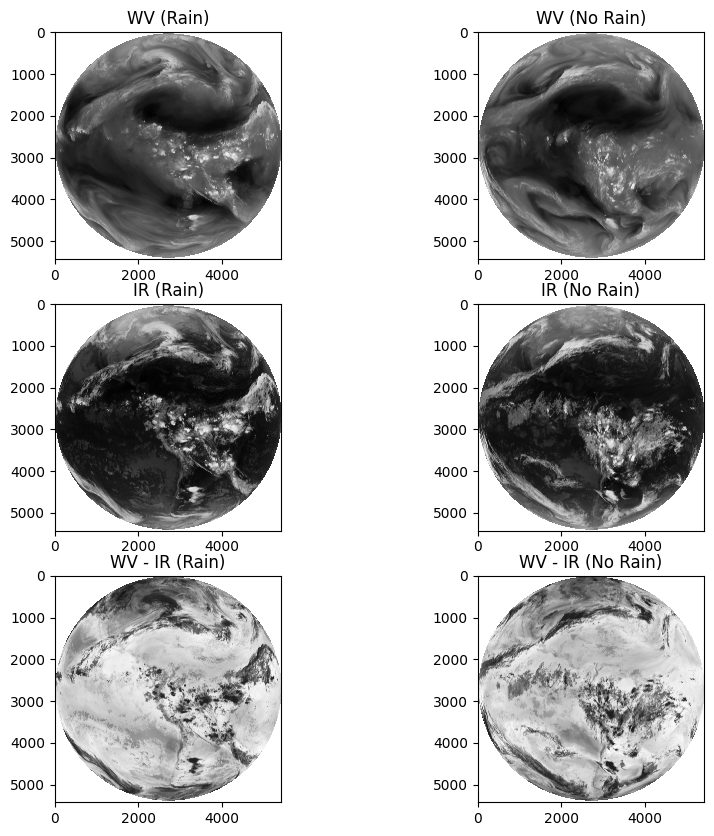

In [36]:
# Training: Python and GOES-R Imagery: Script 1 - Basic Plot / Extracting Pixel Values
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset      # Read / Write NetCDF4 files
import matplotlib.pyplot as plt  # Plotting library
#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R image
# Download files at this link: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi
# file = Dataset("Samples/OR_ABI-L2-CMIPF-M6C13_G16_s20191981200396_e20191981210116_c20191981210189.nc")
file_WV_rain   = Dataset("../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C09_G16_s20240130140204_e20240130149518_c20240130149599.nc")
file_IR_rain   = Dataset("../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C13_G16_s20240130140204_e20240130149524_c20240130149589.nc")
file_WV_norain = Dataset("../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C09_G16_s20240430140205_e20240430149519_c20240430149579.nc")
file_IR_norain = Dataset("../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C13_G16_s20240430140205_e20240430149525_c20240430149589.nc")

# Get the pixel values
data_WV_rain = file_WV_rain.variables['CMI'][:]
data_WV_norain = file_WV_norain.variables['CMI'][:]
data_IR_rain = file_IR_rain.variables['CMI'][:]
data_IR_norain = file_IR_norain.variables['CMI'][:]

data_diff_rain = data_WV_rain - data_IR_rain
data_diff_norain = data_WV_norain - data_IR_norain

print(data_WV_rain.shape, data_WV_norain.shape)
print(data_IR_rain.shape, data_IR_norain.shape)
print(data_diff_rain.shape, data_diff_norain.shape)

print(f"WV_rain - min/max values: {np.min(data_WV_rain), np.max(data_WV_rain)}")
print(f"WV_norain - min/max values: {np.min(data_WV_norain), np.max(data_WV_norain)}")

print(f"IR_rain - min/max values: {np.min(data_IR_rain), np.max(data_IR_rain)}")
print(f"IR_norain - min/max values: {np.min(data_IR_norain), np.max(data_IR_norain)}")

print(f"diff_rain - min/max values: {np.min(data_diff_rain), np.max(data_diff_rain)}")
print(f"diff_norain - min/max values: {np.min(data_diff_norain), np.max(data_diff_norain)}")

data_diff_rain -= np.min(data_diff_rain)
data_diff_norain -= np.min(data_diff_norain)

print(f"diff_rain - min/max values after scaling: {np.min(data_diff_rain), np.max(data_diff_rain)}")
print(f"diff_norain - min/max values after scaling: {np.min(data_diff_norain), np.max(data_diff_norain)}")


#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10, 10))

# Plot the first image
plt.subplot(3, 2, 1)
plt.imshow(data_WV_rain, cmap='Greys')
plt.title('WV (Rain)')

# Plot the second image
plt.subplot(3, 2, 2)
plt.imshow(data_WV_norain, cmap='Greys')
plt.title('WV (No Rain)')

# Plot the first IR image
plt.subplot(3, 2, 3)
plt.imshow(data_IR_rain, cmap='Greys')
plt.title('IR (Rain)')

# Plot the second IR image
plt.subplot(3, 2, 4)
plt.imshow(data_IR_norain, cmap='Greys')
plt.title('IR (No Rain)')

# Plot the first diff image
plt.subplot(3, 2, 5)
plt.imshow(data_diff_rain, cmap='Greys')
plt.title('WV - IR (Rain)')

# Plot the second diff image
plt.subplot(3, 2, 6)
# plt.imshow(data_diff_norain, vmin=193, vmax=313, cmap='Greys')
plt.imshow(data_diff_norain, cmap='Greys')
plt.title('WV - IR (No Rain)')

#-----------------------------------------------------------------------------------------------------------
# Save the image
# plt.savefig('../data/goes16/cloud_depth/Image_01.png')

# Show the image
plt.show()


# Brazil 

In [10]:
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python

def plot_extent(file_name, extent):
    #-----------------------------------------------------------------------------------------------------------
    # Variable
    var = 'CMI'

    # Open the file
    img = gdal.Open(f'NETCDF:{file_name}.nc:' + var)

    # Read the header metadata
    metadata = img.GetMetadata()
    scale = float(metadata.get(var + '#scale_factor'))
    offset = float(metadata.get(var + '#add_offset'))
    undef = float(metadata.get(var + '#_FillValue'))
    dtime = metadata.get('NC_GLOBAL#time_coverage_start')

    # Load the data
    ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

    # Apply the scale, offset and convert to celsius
    ds = (ds * scale + offset) - 273.15

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(img.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = img.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(ds)

    # Define the parameters of the output file
    options = gdal.WarpOptions(format = 'netCDF',
            srcSRS = source_prj,
            dstSRS = target_prj,
            outputBounds = (extent[0], extent[3], extent[2], extent[1]),
            outputBoundsSRS = target_prj,
            outputType = gdal.GDT_Float32,
            srcNodata = undef,
            dstNodata = 'nan',
            xRes = 0.02,
            yRes = 0.02,
            resampleAlg = gdal.GRA_NearestNeighbour)

    print(options)

    # Write the reprojected file on disk
    gdal.Warp(f'{file_name}_ret.nc', raw, options=options)
    #-----------------------------------------------------------------------------------------------------------
    # Open the reprojected GOES-R image
    file = Dataset(f'{file_name}_ret.nc')

    # Get the pixel values
    data = file.variables['Band1'][:]
    #-----------------------------------------------------------------------------------------------------------
    # Choose the plot size (width x height, in inches)
    plt.figure(figsize=(10,10))
    
    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Define the image extent
    img_extent = [extent[0], extent[2], extent[1], extent[3]]

    # Define the color scale based on the channel
    colormap = "gray_r" # White to black for IR channels

    # Plot the image
    img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='white', linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    # Add a colorbar
    plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

    # Extract date
    date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

    # Add a title
    plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
    plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
    #-----------------------------------------------------------------------------------------------------------

    # Show the image
    plt.show()

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff5e8d793e0> >, None, None)


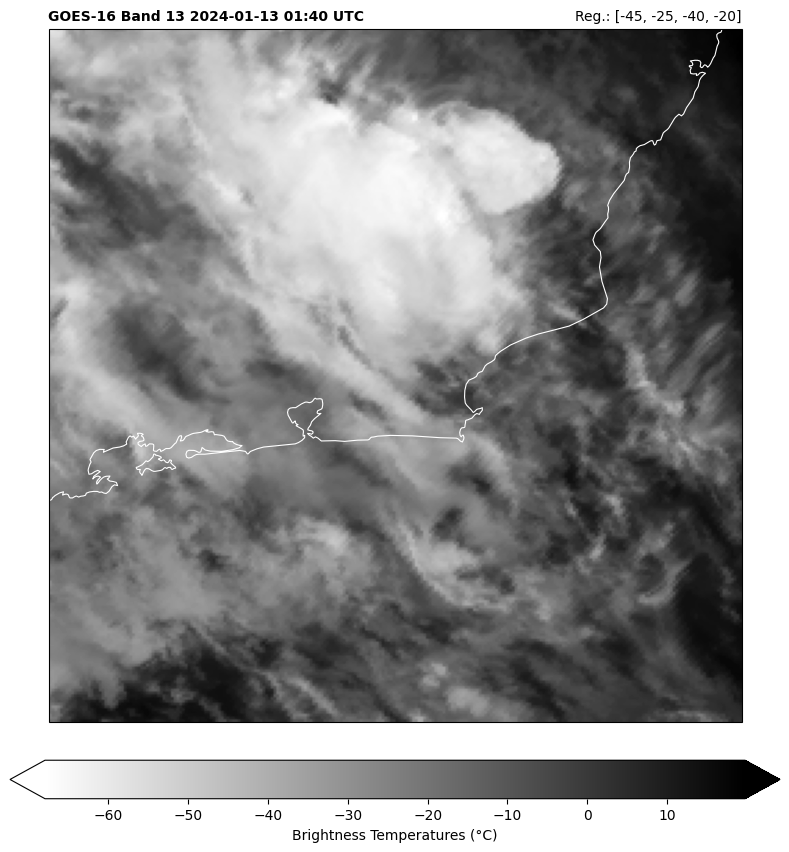

In [11]:
extent = [-45, -25, -40, -20]
file_name = "../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C13_G16_s20240130140204_e20240130149524_c20240130149589"
plot_extent(file_name, extent)

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff5e7f610b0> >, None, None)
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff5e7f60cc0> >, None, None)
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff5e7f626a0> >, None, None)
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff5e7f61080> >, None, None)
<class 'numpy.ma.core.MaskedArray'>
(250, 250) (250, 250)
(250, 250) (250, 250)
(250, 250) (250, 250)


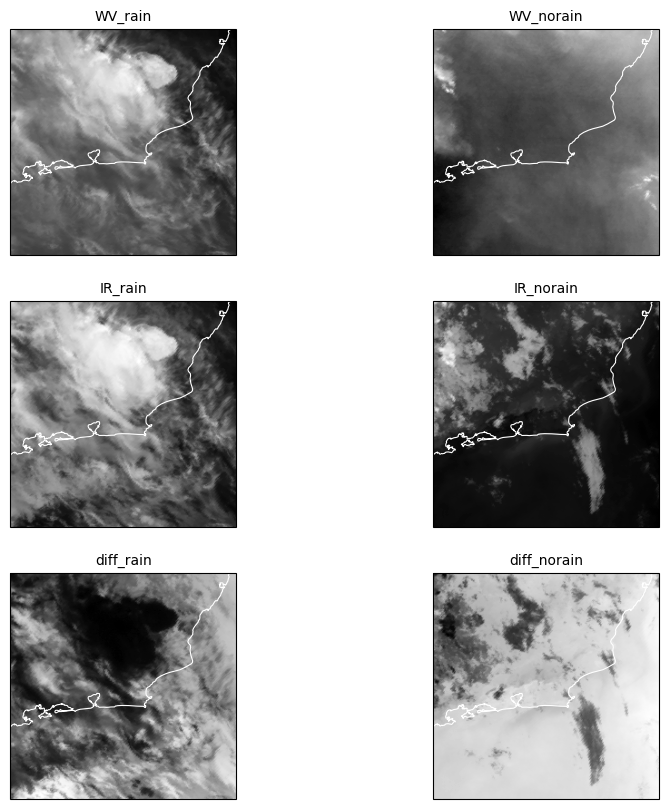

In [34]:
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python

def get_reprojection(file_name, extent):
    #-----------------------------------------------------------------------------------------------------------
    # Variable
    var = 'CMI'

    # Open the file
    img = gdal.Open(f'NETCDF:{file_name}.nc:' + var)

    # Read the header metadata
    metadata = img.GetMetadata()
    scale = float(metadata.get(var + '#scale_factor'))
    offset = float(metadata.get(var + '#add_offset'))
    undef = float(metadata.get(var + '#_FillValue'))
    dtime = metadata.get('NC_GLOBAL#time_coverage_start')

    # Load the data
    ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

    # Apply the scale, offset and convert to celsius
    ds = (ds * scale + offset) - 273.15

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(img.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = img.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(ds)

    # Define the parameters of the output file
    options = gdal.WarpOptions(format = 'netCDF',
            srcSRS = source_prj,
            dstSRS = target_prj,
            outputBounds = (extent[0], extent[3], extent[2], extent[1]),
            outputBoundsSRS = target_prj,
            outputType = gdal.GDT_Float32,
            srcNodata = undef,
            dstNodata = 'nan',
            xRes = 0.02,
            yRes = 0.02,
            resampleAlg = gdal.GRA_NearestNeighbour)

    print(options)

    # Write the reprojected file on disk
    gdal.Warp(f'{file_name}_ret.nc', raw, options=options)
    #-----------------------------------------------------------------------------------------------------------
    # Open the reprojected GOES-R image
    file = Dataset(f'{file_name}_ret.nc')

    # Get the pixel values
    data = file.variables['Band1'][:]

    return data

def plot_extent(data,titles, extent):
    #-----------------------------------------------------------------------------------------------------------
    # Choose the plot size (width x height, in inches)
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Define the image extent
    img_extent = [extent[0], extent[2], extent[1], extent[3]]

    # Define the color scale based on the channel
    colormap = "gray_r" # White to black for IR channels

    i = 0

    for ax in axes.flat:
        # Plot the image
        img = ax.imshow(data[i], origin='upper', extent=img_extent, cmap=colormap)

        # Add coastlines, borders and gridlines
        ax.coastlines(resolution='10m', color='white', linewidth=0.8)
        ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

        # Add a title to each subplot
        ax.set_title(f'{titles[i]}', fontsize=10)

        i += 1

    # Add a colorbar
    # cbar = fig.colorbar(img, ax=axes.ravel().tolist(), label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

    # Extract date
    # date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

    # Add a title
    # plt.suptitle('GOES-16 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=12)
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #-----------------------------------------------------------------------------------------------------------

    # Show the image
    plt.show()

extent = [-45, -25, -40, -20]

file_WV_rain   = "../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C09_G16_s20240130140204_e20240130149518_c20240130149599"
file_WV_norain = "../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C09_G16_s20240430140205_e20240430149519_c20240430149579"
file_IR_rain   = "../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C13_G16_s20240130140204_e20240130149524_c20240130149589"
file_IR_norain = "../data/goes16/cloud_depth/OR_ABI-L2-CMIPF-M6C13_G16_s20240430140205_e20240430149525_c20240430149589"

# Get the pixel values
data_WV_rain = get_reprojection(file_WV_rain, extent)
data_WV_norain = get_reprojection(file_WV_norain, extent)
data_IR_rain = get_reprojection(file_IR_rain, extent)
data_IR_norain = get_reprojection(file_IR_norain, extent)

print(type(data_WV_rain))

data_diff_rain = data_WV_rain - data_IR_rain
data_diff_norain = data_WV_norain - data_IR_norain

print(data_WV_rain.shape, data_WV_norain.shape)
print(data_IR_rain.shape, data_IR_norain.shape)
print(data_diff_rain.shape, data_diff_norain.shape)

data = [data_WV_rain, data_WV_norain, data_IR_rain, data_IR_norain, data_diff_rain, data_diff_norain]
titles = ['WV_rain', 'WV_norain', 'IR_rain', 'IR_norain', 'diff_rain', 'diff_norain']
plot_extent(data, titles, extent)

## Script 02 - Basic Operation / Colorbar / Title / Date

In [26]:
import pandas as pd
import numpy as np

def hourly_average_with_nan_handling(df: pd.DataFrame):
    """
    Resamples a DataFrame containing time series data to an hourly frequency and computes the mean of 
    the 'tpw_value' column.
    
    Parameters:
    df (pd.DataFrame): A pandas DataFrame with a DateTime index and a column named 'tpw_value' containing 
                    the time series data.
    
    Returns:
    pd.DataFrame: A DataFrame with the hourly resampled mean values of the 'tpw_value' column. 
                    The index of the returned DataFrame is shifted by one hour.
    
    Notes:
    - The function resamples the input DataFrame to an hourly frequency and calculates the mean of the 'tpw_value' column for each hour.
    - NaN values are included in the mean calculation. To exclude NaN values, uncomment the line that drops rows with NaN values in 'tpw_value'.
    - The index of the resulting DataFrame is shifted by one hour using `pd.DateOffset(hours=1)` to adjust for any specific time alignment requirements.
    
    Example:
    >>> df = pd.DataFrame({'tpw_value': [1, 2, 3, 4, 5]}, index=pd.date_range('2023-01-01', periods=5, freq='30T'))
    >>> hourly_average_with_nan_handling(df)
                       tpw_value
    2023-01-01 01:00:00       1.5
    2023-01-01 02:00:00       3.5
    2023-01-01 03:00:00       5.0
    """
    # Resample the DataFrame to hourly frequency and compute the mean
    df_resampled = df['tpw_value'].resample('H').mean()
    
    return pd.DataFrame({'tpw_value': df_resampled.values},
                        index=df_resampled.index + pd.DateOffset(hours=1))

In [30]:
df = pd.DataFrame({'tpw_value': [2, 2, 2, np.NaN, 2, 2, 3, 3, 3, 3, 3, 3, np.NaN, 4, 4, 4, np.NaN]}, index=pd.date_range('2023-01-01', periods=17, freq='10T'))
print(df)
print(30*'~')
print(hourly_average_with_nan_handling(df))

                     tpw_value
2023-01-01 00:00:00        2.0
2023-01-01 00:10:00        2.0
2023-01-01 00:20:00        2.0
2023-01-01 00:30:00        NaN
2023-01-01 00:40:00        2.0
2023-01-01 00:50:00        2.0
2023-01-01 01:00:00        3.0
2023-01-01 01:10:00        3.0
2023-01-01 01:20:00        3.0
2023-01-01 01:30:00        3.0
2023-01-01 01:40:00        3.0
2023-01-01 01:50:00        3.0
2023-01-01 02:00:00        NaN
2023-01-01 02:10:00        4.0
2023-01-01 02:20:00        4.0
2023-01-01 02:30:00        4.0
2023-01-01 02:40:00        NaN
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     tpw_value
2023-01-01 01:00:00        2.0
2023-01-01 02:00:00        3.0
2023-01-01 03:00:00        4.0


## Script 14 - Reprojection with GDAL

File ../data/goes16/curso_cptec/Samples/OR_ABI-L2-CMIPF-M6C13_G16_s20210491800058_e20210491809378_c20210491809458.nc exists
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7fdfa470a1f0> >, None, None)


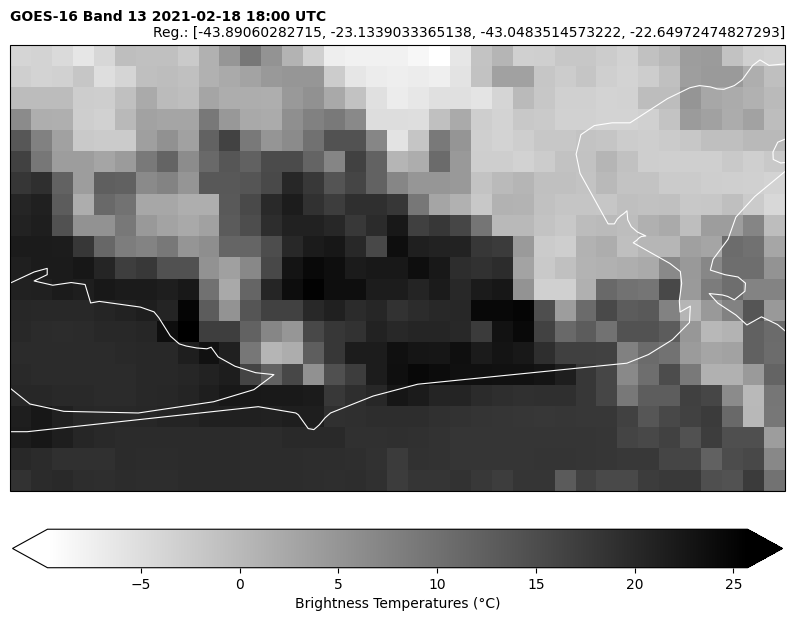

In [17]:
# Training: Python and GOES-R Imagery: Script 14 - Reprojection with GDAL
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python
# from utilities import download_CMI              # Our function for download

#-----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "../data/goes16/curso_cptec/Samples"
output = "../data/goes16/curso_cptec/Output"

# Desired extent
# extent = [-64.0, -35.0, -35.0, -15.0] # Min lon, Max lon, Min lat, Max lat
extent = [-43.890602827150, -23.1339033365138, -43.0483514573222, -22.64972474827293]

# Datetime to process
yyyymmddhhmn = '202102181800'
band = '13'

# Download the file
file_name = download_CMI(yyyymmddhhmn, band, input)

#-----------------------------------------------------------------------------------------------------------
# Variable
var = 'CMI'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_name}.nc:' + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
ds = (ds * scale + offset) - 273.15

# Read the original file projection and configure the output projection
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Reproject the data
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName('MEM')
raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

# Define the parameters of the output file  
options = gdal.WarpOptions(format = 'netCDF', 
          srcSRS = source_prj, 
          dstSRS = target_prj,
          outputBounds = (extent[0], extent[3], extent[2], extent[1]), 
          outputBoundsSRS = target_prj, 
          outputType = gdal.GDT_Float32, 
          srcNodata = undef, 
          dstNodata = 'nan', 
        #   xRes = 0.01, 
        #   yRes = 0.01, 
          resampleAlg = gdal.GRA_NearestNeighbour)

print(options)

# Write the reprojected file on disk
gdal.Warp(f'{output}/{file_name}_ret.nc', raw, options=options)
#-----------------------------------------------------------------------------------------------------------
# Open the reprojected GOES-R image
file = Dataset(f'{output}/{file_name}_ret.nc')

# Get the pixel values
data = file.variables['Band1'][:]
#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
colormap = "gray_r" # White to black for IR channels
    
# Plot the image
img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC\n', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
# plt.savefig(f'{output}/Image_14.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()

In [11]:
metadata

{'CMI#add_offset': '89.620003',
 'CMI#ancillary_variables': 'DQF',
 'CMI#cell_methods': 't: point area: point',
 'CMI#coordinates': 'band_id band_wavelength t y x',
 'CMI#grid_mapping': 'goes_imager_projection',
 'CMI#long_name': 'ABI L2+ Cloud and Moisture Imagery brightness temperature',
 'CMI#resolution': 'y: 0.000056 rad x: 0.000056 rad',
 'CMI#scale_factor': '0.06145332',
 'CMI#sensor_band_bit_depth': '12',
 'CMI#standard_name': 'toa_brightness_temperature',
 'CMI#units': 'K',
 'CMI#valid_range': '{0,4095}',
 'CMI#_FillValue': '-1',
 'CMI#_Unsigned': 'true',
 'goes_imager_projection#grid_mapping_name': 'geostationary',
 'goes_imager_projection#inverse_flattening': '298.2572221',
 'goes_imager_projection#latitude_of_projection_origin': '0',
 'goes_imager_projection#longitude_of_projection_origin': '-75',
 'goes_imager_projection#long_name': 'GOES-R ABI fixed grid projection',
 'goes_imager_projection#perspective_point_height': '35786023',
 'goes_imager_projection#semi_major_axis': 

In [9]:
from netCDF4 import Dataset

filename = '../data/goes16/DSI/DSI2021_Jan_to_May/202102010000_CAPE.nc'

file = Dataset(f'{filename}')

# Get the pixel values
data = file.variables['Band1'][:]

data[0,0]

429.11642

In [10]:
data.shape

(4, 7)

In [28]:
import pandas as pd

df_CAPE = pd.read_parquet('../CAPE.parquet')

df_CAPE.tail(150)

,CAPE00,CAPE01,CAPE02,CAPE03,CAPE04,CAPE05,CAPE06,CAPE10,CAPE11,CAPE12,...,CAPE24,CAPE25,CAPE26,CAPE30,CAPE31,CAPE32,CAPE33,CAPE34,CAPE35,CAPE36
timestamp,,,,,,,,,,,,,,,,,,,,,
202104222030,47.077671,46.162060,23.500685,19.227833,0.0,0.0,5.112162,47.153973,50.206009,8.698306,...,16.404699,16.404699,16.404699,19.609339,15.336486,15.183885,16.862505,5000.381348,5000.381348,35.327328
202104222040,5000.381348,5000.381348,19.304134,22.966579,0.0,0.0,4.425454,50.587513,57.454597,11.216236,...,17.549213,17.549213,20.296047,21.440561,17.396612,17.778116,19.685638,25.484510,5000.381348,25.560810
202104222050,52.647640,49.214096,24.111094,16.404699,0.0,0.0,7.248588,59.056919,60.201431,14.649778,...,22.661375,22.661375,26.400122,23.195482,20.296047,20.067144,25.026705,28.383945,32.733097,32.580494
202104222100,5000.381348,61.651150,20.601250,24.263695,0.0,0.0,7.858995,47.688080,60.964439,14.497176,...,31.817486,31.817486,30.825575,24.034792,17.472912,17.625515,23.653288,31.054478,42.270714,30.596672
202104222110,5000.381348,5000.381348,19.609339,27.163130,0.0,0.0,11.368838,32.580494,63.406071,14.802380,...,5000.381348,5000.381348,33.496105,24.034792,20.601250,20.830153,23.958490,31.359680,42.499615,45.780556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202104232130,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
202104232140,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
202104232150,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
df_CAPE.shape

(15624, 28)

In [29]:
import pandas as pd
df_A601 = pd.read_parquet('../data/ws/inmet/A601.parquet')
df_A601.tail()

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
4027,SEROPÉDICA-ECOLOGIA AGRÍCOLA,NaN,NaN,-22.757778,NaN,RJ,NaN,NaN,NaN,-43.684722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A601,1900
4028,SEROPÉDICA-ECOLOGIA AGRÍCOLA,NaN,NaN,-22.757778,NaN,RJ,NaN,NaN,NaN,-43.684722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A601,2000
4029,SEROPÉDICA-ECOLOGIA AGRÍCOLA,NaN,NaN,-22.757778,NaN,RJ,NaN,NaN,NaN,-43.684722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A601,2100
4030,SEROPÉDICA-ECOLOGIA AGRÍCOLA,NaN,NaN,-22.757778,NaN,RJ,NaN,NaN,NaN,-43.684722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A601,2200
4031,SEROPÉDICA-ECOLOGIA AGRÍCOLA,NaN,NaN,-22.757778,NaN,RJ,NaN,NaN,NaN,-43.684722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A601,2300


In [36]:
import pandas as pd

import pandas as pd

def aggregate_to_hourly_resolution(df):
    """
    Aggregates the rows of a DataFrame to an hourly temporal resolution using the mean.

    Parameters:
    df (pd.DataFrame): DataFrame with a datetime index named 'timestamp' and numeric columns.

    Returns:
    pd.DataFrame: DataFrame aggregated to hourly temporal resolution.
    """
    # Ensure the index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Resample the DataFrame to hourly frequency and compute the mean
    hourly_df = df.resample('H').mean()

    hourly_df.set_index(hourly_df.index + pd.DateOffset(hours=1), inplace=True)

    return hourly_df

# Example usage
# Assuming df is your DataFrame with a datetime index 'timestamp'
# df = pd.read_csv('your_data.csv', index_col='timestamp', parse_dates=True)
# hourly_df = aggregate_to_hourly_resolution(df)
# print(hourly_df)

# Create a sample DataFrame
data = {
    'timestamp': pd.date_range(start='2023-01-01', periods=9, freq='10T'),
    'numeric_col1': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'numeric_col2': [10, 20, 30, 40, 50, 60, 70, 80, 90]
}
df = pd.DataFrame(data)
df.set_index('timestamp', inplace=True)

# Call the function to aggregate to hourly resolution
hourly_df = aggregate_to_hourly_resolution(df)

print(df)
print('~~~')
# Print the result
print(hourly_df)


                     numeric_col1  numeric_col2
timestamp                                      
2023-01-01 00:00:00             1            10
2023-01-01 00:10:00             2            20
2023-01-01 00:20:00             3            30
2023-01-01 00:30:00             4            40
2023-01-01 00:40:00             5            50
2023-01-01 00:50:00             6            60
2023-01-01 01:00:00             7            70
2023-01-01 01:10:00             8            80
2023-01-01 01:20:00             9            90
~~~
                     numeric_col1  numeric_col2
timestamp                                      
2023-01-01 01:00:00           3.5          35.0
2023-01-01 02:00:00           8.0          80.0


In [5]:
import pandas as pd

df = pd.read_parquet('../dsi_features.parquet')
df.tail()

,CAPE,LI,TT,SI,KI
timestamp,,,,,
2024-05-31 20:00:00,5000.381348,40.003860,60.007912,25.002899,50.009003
2024-05-31 21:00:00,3333.587565,27.793920,53.770224,19.320859,35.281721
2024-05-31 22:00:00,0.000000,3.396167,41.195563,7.979567,5.948323
2024-05-31 23:00:00,5000.381348,40.003860,60.007912,25.002899,50.009003
2024-06-01 00:00:00,5000.381348,40.003860,60.007912,25.002899,50.009003


In [4]:
df.shape

(39345, 5)

In [8]:
df1 = df[df.isna().any(axis=1)]
df1.head(100)

,CAPE,LI,TT,SI,KI
timestamp,,,,,
2020-06-01 01:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-01 03:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-01 04:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-01 05:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-06-05 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-05 01:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-05 02:00:00,NaN,NaN,NaN,NaN,NaN


In [40]:
for index in ['CAPE', 'LI', 'TT', 'SI', 'KI']:
    df = pd.read_parquet(f'../data/goes16/DSI/DSI_{index}.parquet')
    print(df.shape, df[df.isna().any(axis=1)].shape)

(175005, 29) (0, 29)
(175005, 29) (0, 29)
(175005, 29) (0, 29)
(175005, 29) (0, 29)
(175005, 29) (0, 29)


In [57]:
initial_timestamp = '2021-01-21 19:00:00'
final_timestamp = '2021-01-21 23:00:00'
df.loc[initial_timestamp:final_timestamp].index

DatetimeIndex(['2021-01-21 19:00:00', '2021-01-21 19:10:00',
               '2021-01-21 19:20:00', '2021-01-21 22:10:00',
               '2021-01-21 22:20:00', '2021-01-21 22:30:00',
               '2021-01-21 22:40:00', '2021-01-21 22:50:00',
               '2021-01-21 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

The missing data can also be noticed in https://noaa-goes16.s3.amazonaws.com/index.html#ABI-L2-DSIF/2021/021/

In [58]:
initial_timestamp = '2021-01-22 19:00:00'
final_timestamp = '2021-01-22 23:00:00'
df.loc[initial_timestamp:final_timestamp].index

DatetimeIndex(['2021-01-22 19:00:00', '2021-01-22 19:10:00',
               '2021-01-22 19:20:00', '2021-01-22 19:30:00',
               '2021-01-22 19:40:00', '2021-01-22 19:50:00',
               '2021-01-22 20:00:00', '2021-01-22 20:10:00',
               '2021-01-22 20:20:00', '2021-01-22 20:30:00',
               '2021-01-22 20:40:00', '2021-01-22 20:50:00',
               '2021-01-22 21:00:00', '2021-01-22 21:10:00',
               '2021-01-22 21:20:00', '2021-01-22 21:30:00',
               '2021-01-22 21:40:00', '2021-01-22 21:50:00',
               '2021-01-22 22:00:00', '2021-01-22 22:10:00',
               '2021-01-22 22:20:00', '2021-01-22 22:30:00',
               '2021-01-22 22:40:00', '2021-01-22 22:50:00',
               '2021-01-22 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [35]:
def aggregate_to_hourly_resolution(df: pd.DataFrame):
    assert (not df.isnull().values.any().any())

    # Resample the DataFrame to hourly frequency and compute the mean
    hourly_df = df.resample('H').mean()

    hourly_df.set_index(hourly_df.index + pd.DateOffset(hours=1), inplace=True)

    hourly_df = hourly_df.dropna()
    
    return hourly_df

In [37]:
for index in ['CAPE', 'LI', 'TT', 'SI', 'KI']:
    df = pd.read_parquet(f'../data/goes16/DSI/DSI_{index}_1H.parquet')
    print(df.shape, df[df.isna().any(axis=1)].shape)

(30298, 28) (0, 28)
(30298, 28) (0, 28)
(30298, 28) (0, 28)
(30298, 28) (0, 28)
(30298, 28) (0, 28)


In [61]:
from datetime import datetime

date_str = '03-23-2021'

date_object = datetime.strptime(date_str, '%m-%d-%Y').date()
print(type(date_object))
print(date_object)  # printed in default format

day_of_year = date_object.timetuple().tm_yday
print(day_of_year)

<class 'datetime.date'>
2021-03-23
82


In [39]:
date_to_filter = '2021-03-23'
df.loc[date_to_filter].index

DatetimeIndex(['2021-03-23 00:00:00', '2021-03-23 01:00:00',
               '2021-03-23 02:00:00', '2021-03-23 03:00:00',
               '2021-03-23 04:00:00', '2021-03-23 05:00:00',
               '2021-03-23 06:00:00', '2021-03-23 07:00:00',
               '2021-03-23 08:00:00', '2021-03-23 09:00:00',
               '2021-03-23 10:00:00', '2021-03-23 11:00:00',
               '2021-03-23 12:00:00', '2021-03-23 13:00:00',
               '2021-03-23 14:00:00', '2021-03-23 22:00:00',
               '2021-03-23 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [16]:
df.tail()

,KI00,KI01,KI02,KI03,KI04,KI05,KI06,KI10,KI11,KI12,...,KI24,KI25,KI26,KI30,KI31,KI32,KI33,KI34,KI35,KI36
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-31 20:00:00,42.538236,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,27.922658,6.185772,6.665551,...,50.009003,50.009003,50.009003,5.894608,28.089910,28.367034,35.680317,50.009003,50.009003,50.009003
2024-05-31 21:00:00,50.009003,35.281721,50.009003,50.009003,50.009003,50.009003,50.009003,5.944051,6.347224,14.367357,...,50.009003,50.009003,50.009003,5.811592,27.993160,35.389458,35.532293,50.009003,50.009003,50.009003
2024-05-31 22:00:00,27.729770,5.948323,50.009003,50.009003,50.009003,50.009003,50.009003,5.618093,6.574906,28.223589,...,50.009003,50.009003,50.009003,5.846080,13.315627,28.112190,50.009003,50.009003,50.009003,50.009003
2024-05-31 23:00:00,4.826701,50.009003,12.534917,50.009003,50.009003,50.009003,50.009003,35.239908,42.803457,50.009003,...,50.009003,50.009003,50.009003,50.009003,42.676187,50.009003,50.009003,50.009003,50.009003,50.009003
2024-06-01 00:00:00,4.809000,50.009003,5.041564,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,...,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003,50.009003
